In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

In [3]:
df = pd.read_csv('cars45_detailed_data.csv')

In [4]:
df['price_clean'] = df['price'].str.replace('₦', '').str.replace(',', '').str.strip()
df['price_clean'] = pd.to_numeric(df['price_clean'], errors='coerce')

In [5]:
df['mileage_clean'] = pd.to_numeric(df['Mileage'], errors='coerce')

In [7]:
df['year_clean'] = pd.to_numeric(df['Year of manufacture'], errors='coerce')

In [8]:
current_year = datetime.now().year
df['car_age'] = current_year - df['year_clean']

In [15]:
# extract state and city from location
def extract_state(location):
    try:
        if pd.isna(location):
            return None
        parts = location.split(',')
        return parts[0].strip() if len(parts) > 0 else None
    except:
        return None

In [16]:
def extract_city(location):
    try:
        if pd.isna(location):
            return None
        parts = location.split(',')
        return parts[1].strip() if len(parts) > 1 else None
    except:
        return None

In [17]:
df['state'] = df['location'].apply(extract_state)
df['city'] = df['location'].apply(extract_city)

In [18]:
df['engine_size_clean'] = pd.to_numeric(df['Engine Size'], errors='coerce')

In [19]:
df['horse_power_clean'] = pd.to_numeric(df['Horse Power'], errors='coerce')

In [20]:
df_clean = df.dropna(subset=['price_clean', 'year_clean', 'Make'])

In [21]:
df_clean = df_clean[df_clean['price_clean'] > 0]
df_clean = df_clean[df_clean['car_age'] >= 0]
df_clean = df_clean[df_clean['car_age'] <= 50]

In [22]:

# sample of cleaned data
df_clean[['Make', 'Model', 'year_clean', 'car_age', 'price_clean',
          'mileage_clean', 'state', 'city']].head(10)

After cleaning: 2175

Sample of cleaned data:


,Make,Model,year_clean,car_age,price_clean,mileage_clean,state,city
0,Mercedes-Benz,E350,2011,15,8925000,125114.0,Lagos State,Magodo
1,Mercedes-Benz,M Class,2014,12,16548000,102757.0,Lagos State,Lekki
2,Toyota,Prius,2016,10,15750000,361341.0,Abuja (FCT),Wuse
3,Acura,MDX,2009,17,5880000,123652.0,Lagos State,Lekki
4,Mercedes-Benz,E300,2018,8,24360000,49628.0,Lagos State,Lekki
5,Honda,Accord,2013,13,8400000,76953.0,Lagos State,Lekki
6,Toyota,Highlander,2002,24,4452000,118454.0,Lagos State,Kosofe
7,Lexus,RX 330,2004,22,6825000,178445.0,Lagos State,Abule Egba
8,Toyota,Camry,2012,14,6300000,253849.0,Ondo State,Akure
9,Toyota,Venza,2011,15,11602500,103483.0,Lagos State,Lekki


In [ ]:
import psycopg2

conn = psycopg2.connect(
    dbname='car_analysis',
    user='postgres',
    password='_',
    host='localhost',
    port=5432
)

cursor = conn.cursor()

# create the cars table
create_table_query = """
CREATE TABLE IF NOT EXISTS cars (
    id SERIAL PRIMARY KEY,
    make VARCHAR(100),
    model VARCHAR(100),
    year INTEGER,
    car_age INTEGER,
    trim VARCHAR(200),
    colour VARCHAR(50),
    condition VARCHAR(50),
    bought_condition VARCHAR(50),
    selling_condition VARCHAR(50),
    price NUMERIC(12, 2),
    mileage INTEGER,
    engine_size INTEGER,
    horse_power INTEGER,
    drivetrain VARCHAR(50),
    cylinders INTEGER,
    seats INTEGER,
    registered_city VARCHAR(100),
    state VARCHAR(100),
    city VARCHAR(100),
    detail_url TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

CREATE INDEX IF NOT EXISTS idx_make_model ON cars(make, model);
CREATE INDEX IF NOT EXISTS idx_year ON cars(year);
CREATE INDEX IF NOT EXISTS idx_price ON cars(price);
CREATE INDEX IF NOT EXISTS idx_state ON cars(state);
CREATE INDEX IF NOT EXISTS idx_car_age ON cars(car_age);
"""

cursor.execute(create_table_query)
conn.commit()

print("created successfully")

cursor.close()
conn.close()

created successfully


In [ ]:
import psycopg2
from psycopg2.extras import execute_values

conn = psycopg2.connect(
    dbname='car_analysis',
    user='postgres',
    password='_',
    host='localhost',
    port=5432
)

cursor = conn.cursor()

def safe_int(value):
    try:
        if pd.isna(value):
            return None
        if isinstance(value, str) and '-' in value:
            return int(value.split('-')[0])
        return int(float(value))
    except:
        return None

insert_data = []

for _, row in df_clean.iterrows():
    insert_data.append((
        row['Make'],
        row['Model'],
        safe_int(row['year_clean']),
        safe_int(row['car_age']),
        row['Trim'] if pd.notna(row['Trim']) else None,
        row['Colour'] if pd.notna(row['Colour']) else None,
        row['Condition'] if pd.notna(row['Condition']) else None,
        row['Bought Condition'] if pd.notna(row['Bought Condition']) else None,
        row['Selling Condition'] if pd.notna(row['Selling Condition']) else None,
        float(row['price_clean']) if pd.notna(row['price_clean']) else None,
        safe_int(row['mileage_clean']),
        safe_int(row['engine_size_clean']),
        safe_int(row['horse_power_clean']),
        row['Drivetrain'] if pd.notna(row['Drivetrain']) else None,
        safe_int(row['Number of Cylinders']),
        safe_int(row['Seats']),  # Now handles "5-7" safely
        row['Registered city'] if pd.notna(row['Registered city']) else None,
        row['state'] if pd.notna(row['state']) else None,
        row['city'] if pd.notna(row['city']) else None,
        row['detail_url'] if pd.notna(row['detail_url']) else None
    ))

#insert query
insert_query = """
INSERT INTO cars (
    make, model, year, car_age, trim, colour, condition,
    bought_condition, selling_condition, price, mileage,
    engine_size, horse_power, drivetrain, cylinders, seats,
    registered_city, state, city, detail_url
) VALUES %s
"""

execute_values(cursor, insert_query, insert_data)
conn.commit()

print(f"inserted {len(insert_data)} cars into database")

# Verify the data
cursor.execute("SELECT COUNT(*) FROM cars")
count = cursor.fetchone()[0]
print(f"Total cars in database: {count}")

cursor.close()
conn.close()

inserted 2175 cars into database
Total cars in database: 4350


In [ ]:
import psycopg2
import pandas as pd

conn = psycopg2.connect(
    dbname='car_analysis',
    user='postgres',
    password='_',
    host='localhost',
    port=5432
)

query1 = """
SELECT
    car_age,
    COUNT(*) as num_cars,
    ROUND(AVG(price), 2) as avg_price,
    ROUND(MIN(price), 2) as min_price,
    ROUND(MAX(price), 2) as max_price
FROM cars
WHERE car_age IS NOT NULL AND price IS NOT NULL
GROUP BY car_age
ORDER BY car_age
"""

df_age_analysis = pd.read_sql_query(query1, conn)

print(" AVERAGE PRICE BY CAR AGE \n")
print(df_age_analysis)

conn.close()

 AVERAGE PRICE BY CAR AGE 

    car_age  num_cars    avg_price   min_price    max_price
0         1         9  91733333.33  36750000.0  357000000.0
1         2        11  95118181.82  34650000.0  226800000.0
2         3         9  60165000.00  17850000.0  136500000.0
3         4         9  62226038.89  36746850.0   94500000.0
4         5        26  65327403.85  22575000.0  252000000.0
5         6        32  51207187.50  13125000.0  124950000.0
6         7        29  35401370.69  13650000.0   88400000.0
7         8        66  32970169.74   7875000.0  100880000.0
8         9        61  28857472.13  12600000.0   79800000.0
9        10       119  25140658.61   5250000.0   84000000.0
10       11       147  17414869.20   4725000.0   48880000.0
11       12       157  17915028.24   2310000.0   61360000.0
12       13       162  15025399.93   4515000.0   47302500.0
13       14       151  12231080.87   3360000.0   40560000.0
14       15       143  10559429.93   4200000.0   26250000.0
15       16 

C:\Users\User\AppData\Local\Temp\ipykernel_46548\420569107.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_age_analysis = pd.read_sql_query(query1, conn)


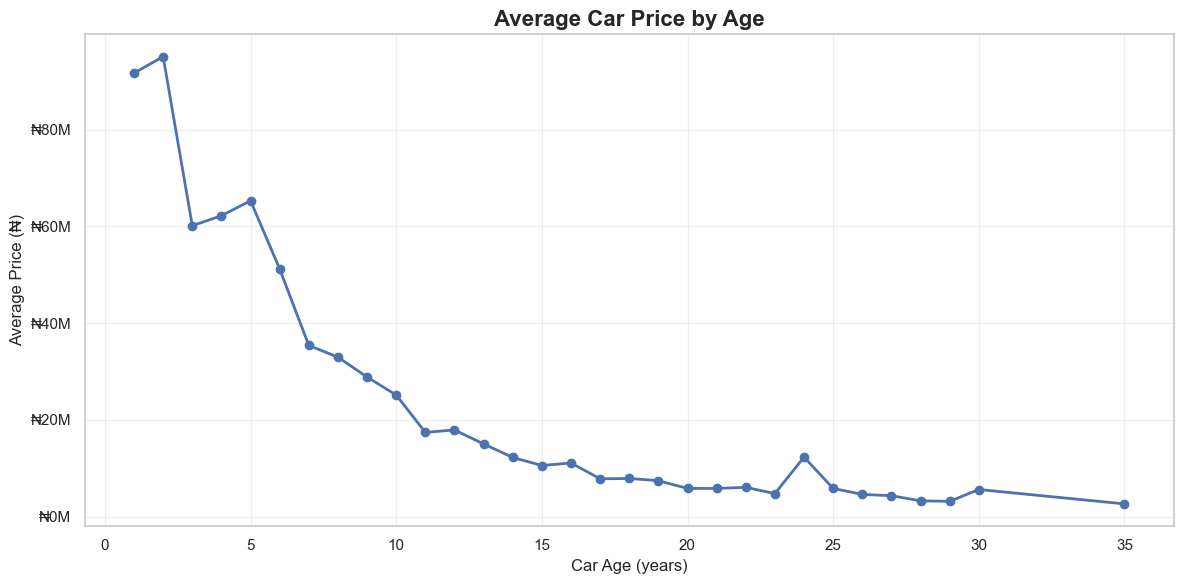


Cars lose ~72.6% of their value in the first 10 years!


In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_age_analysis['car_age'], df_age_analysis['avg_price'],
         marker='o', linewidth=2, markersize=6)

plt.title('Average Car Price by Age', fontsize=16, fontweight='bold')
plt.xlabel('Car Age (years)', fontsize=12)
plt.ylabel('Average Price (₦)', fontsize=12)
plt.grid(True, alpha=0.3)

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₦{x/1_000_000:.0f}M'))

plt.tight_layout()
plt.show()

print(f"\nCars lose ~{((df_age_analysis.iloc[0]['avg_price'] - df_age_analysis.iloc[9]['avg_price']) / df_age_analysis.iloc[0]['avg_price'] * 100):.1f}% of their value in the first 10 years!")

C:\Users\User\AppData\Local\Temp\ipykernel_46548\470255959.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_location = pd.read_sql_query(query2, conn)


 AVERAGE PRICE BY STATE 

              state  num_cars    avg_price  avg_age  avg_mileage
0         Edo State        29  17338448.28     15.2     150180.0
1       Lagos State      1254  16259857.09     14.8     198540.0
2       Abuja (FCT)       357  15412941.25     14.9     210259.0
3         Oyo State       193  14171054.40     16.2     211097.0
4      Rivers State       116  13788857.76     15.8     178874.0
5       Enugu State        24  12841625.00     16.5     179062.0
6   Akwa Ibom State        19  12522263.16     15.6     182949.0
7       Delta State        37  12073027.03     16.5     237785.0
8         Imo State        19  11002401.32     17.2     226670.0
9        Kano State        11  10744090.91     17.8     197155.0
10       Abia State        17  10393823.53     17.1     230053.0
11     Kaduna State        19  10118710.53     16.8     197519.0
12       Ogun State        57   9730561.40     17.3     260499.0
13       Ondo State        23   8047217.39     18.1     263189.0

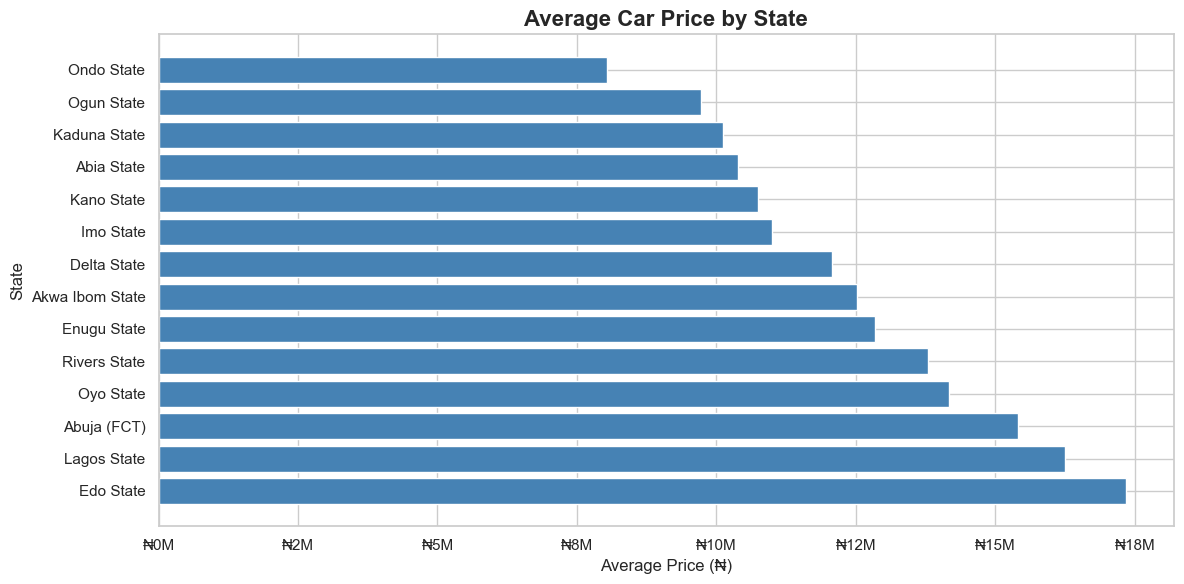

In [ ]:
conn = psycopg2.connect(
    dbname='car_analysis',
    user='postgres',
    password='_',
    host='localhost',
    port=5432
)

query2 = """
SELECT
    state,
    COUNT(*) as num_cars,
    ROUND(AVG(price), 2) as avg_price,
    ROUND(AVG(car_age), 1) as avg_age,
    ROUND(AVG(mileage), 0) as avg_mileage
FROM cars
WHERE state IS NOT NULL AND price IS NOT NULL
GROUP BY state
HAVING COUNT(*) >= 10
ORDER BY avg_price DESC
"""

df_location = pd.read_sql_query(query2, conn)

print(" AVERAGE PRICE BY STATE \n")
print(df_location)

plt.figure(figsize=(12, 6))
plt.barh(df_location['state'], df_location['avg_price'], color='steelblue')
plt.xlabel('Average Price (₦)', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.title('Average Car Price by State', fontsize=16, fontweight='bold')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'₦{x/1_000_000:.0f}M'))
plt.tight_layout()
plt.show()

conn.close()

C:\Users\User\AppData\Local\Temp\ipykernel_46548\88643207.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_depreciation = pd.read_sql_query(query3, conn)


 BRANDS WITH HIGHEST DEPRECIATION (First 10 Years) 

            make  avg_price_new  avg_price_10yrs  depreciation_pct
0          Lexus    357000000.0      49700000.00             86.08
1  Mercedes-Benz    226800000.0      45777596.15             79.82
2         Toyota    100275000.0      28995713.77             71.08
3          Honda     78000000.0      25555550.00             67.24
4            GAC     34650000.0      14175000.00             59.09


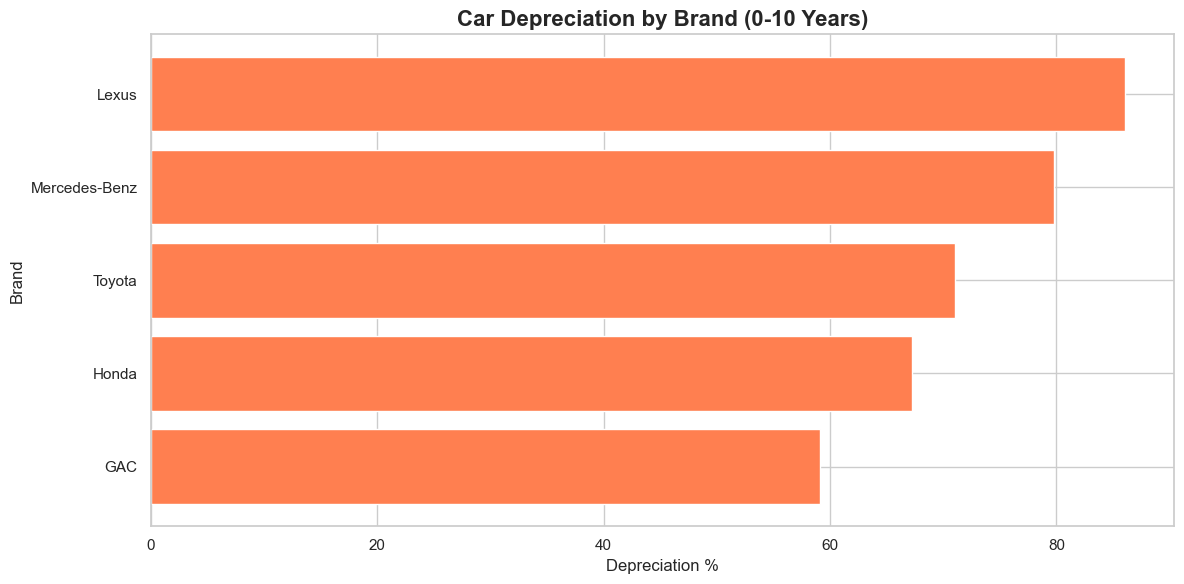

In [ ]:
conn = psycopg2.connect(
    dbname='car_analysis',
    user='postgres',
    password='_',
    host='localhost',
    port=5432
)

query3 = """
WITH brand_age_price AS (
    SELECT
        make,
        car_age,
        AVG(price) as avg_price
    FROM cars
    WHERE car_age BETWEEN 0 AND 10
        AND price IS NOT NULL
    GROUP BY make, car_age
),
depreciation_calc AS (
    SELECT
        make,
        MAX(CASE WHEN car_age <= 2 THEN avg_price END) as new_price,
        MAX(CASE WHEN car_age BETWEEN 8 AND 10 THEN avg_price END) as old_price
    FROM brand_age_price
    GROUP BY make
)
SELECT
    make,
    ROUND(new_price, 2) as avg_price_new,
    ROUND(old_price, 2) as avg_price_10yrs,
    ROUND(((new_price - old_price) / new_price * 100), 2) as depreciation_pct
FROM depreciation_calc
WHERE new_price IS NOT NULL
    AND old_price IS NOT NULL
    AND new_price > old_price
ORDER BY depreciation_pct DESC
LIMIT 15
"""

df_depreciation = pd.read_sql_query(query3, conn)

print(" BRANDS WITH HIGHEST DEPRECIATION (First 10 Years) \n")
print(df_depreciation)

plt.figure(figsize=(12, 6))
plt.barh(df_depreciation['make'], df_depreciation['depreciation_pct'], color='coral')
plt.xlabel('Depreciation %', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.title('Car Depreciation by Brand (0-10 Years)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

conn.close()

In [ ]:
conn = psycopg2.connect(
    dbname='car_analysis',
    user='postgres',
    password='_',
    host='localhost',
    port=5432
)

query4 = """
SELECT
    make,
    model,
    year,
    car_age,
    price,
    mileage,
    state,
    city,
    ROUND(price / NULLIF(mileage, 0), 2) as price_per_km,
    condition
FROM cars
WHERE mileage > 0
    AND mileage < 200000
    AND price < 20000000
    AND car_age <= 15
ORDER BY price_per_km ASC
LIMIT 20
"""

df_best_value = pd.read_sql_query(query4, conn)

print("TOP 20 BEST VALUE CARS (Lowest Price per KM)\n")
print(df_best_value)

query5 = """
SELECT
    make,
    model,
    year,
    price,
    mileage,
    state,
    city,
    condition
FROM cars
WHERE mileage < 100000
    AND price < 10000000
    AND car_age <= 10
    AND condition IS NOT NULL
ORDER BY price ASC, mileage ASC
LIMIT 15
"""

df_affordable_low_mileage = pd.read_sql_query(query5, conn)

print("\n AFFORDABLE CARS WITH LOW MILEAGE (<100k km, <₦10M)\n")
print(df_affordable_low_mileage)

conn.close()

TOP 20 BEST VALUE CARS (Lowest Price per KM)

       make    model  year  car_age      price  mileage         state  \
0       Kia      Rio  2014       12  2310000.0   133130    Ogun State   
1      Ford   Fusion  2011       15  4200000.0   174221   Lagos State   
2       Kia   Cerato  2012       14  3885000.0   156074   Lagos State   
3     Honda   Accord  2012       14  5250000.0   192126    Ondo State   
4    Nissan   Sentra  2013       13  4889850.0   173574   Lagos State   
5    Nissan   Sentra  2013       13  4889850.0   173574   Lagos State   
6   Peugeot      408  2011       15  5250000.0   186216   Abuja (FCT)   
7   Peugeot      408  2011       15  5250000.0   186216   Abuja (FCT)   
8   Hyundai   Accent  2012       14  5250000.0   186119   Abuja (FCT)   
9    Nissan   Almera  2016       10  5250000.0   179246  Kaduna State   
10   Nissan   Almera  2016       10  5250000.0   179246  Kaduna State   
11     Ford    Focus  2013       13  4515000.0   136331   Lagos State   
12   

C:\Users\User\AppData\Local\Temp\ipykernel_46548\3955869119.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_best_value = pd.read_sql_query(query4, conn)
C:\Users\User\AppData\Local\Temp\ipykernel_46548\3955869119.py:54: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_affordable_low_mileage = pd.read_sql_query(query5, conn)


C:\Users\User\AppData\Local\Temp\ipykernel_46548\1638330428.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sum = pd.read_sql_query(query_summary, conn)
C:\Users\User\AppData\Local\Temp\ipykernel_46548\1638330428.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_brands = pd.read_sql_query(query_brands, conn)
C:\Users\User\AppData\Local\Temp\ipykernel_46548\1638330428.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='make', data=df_brands, palette='viridis', ax=ax_bar, edgecolor=None)


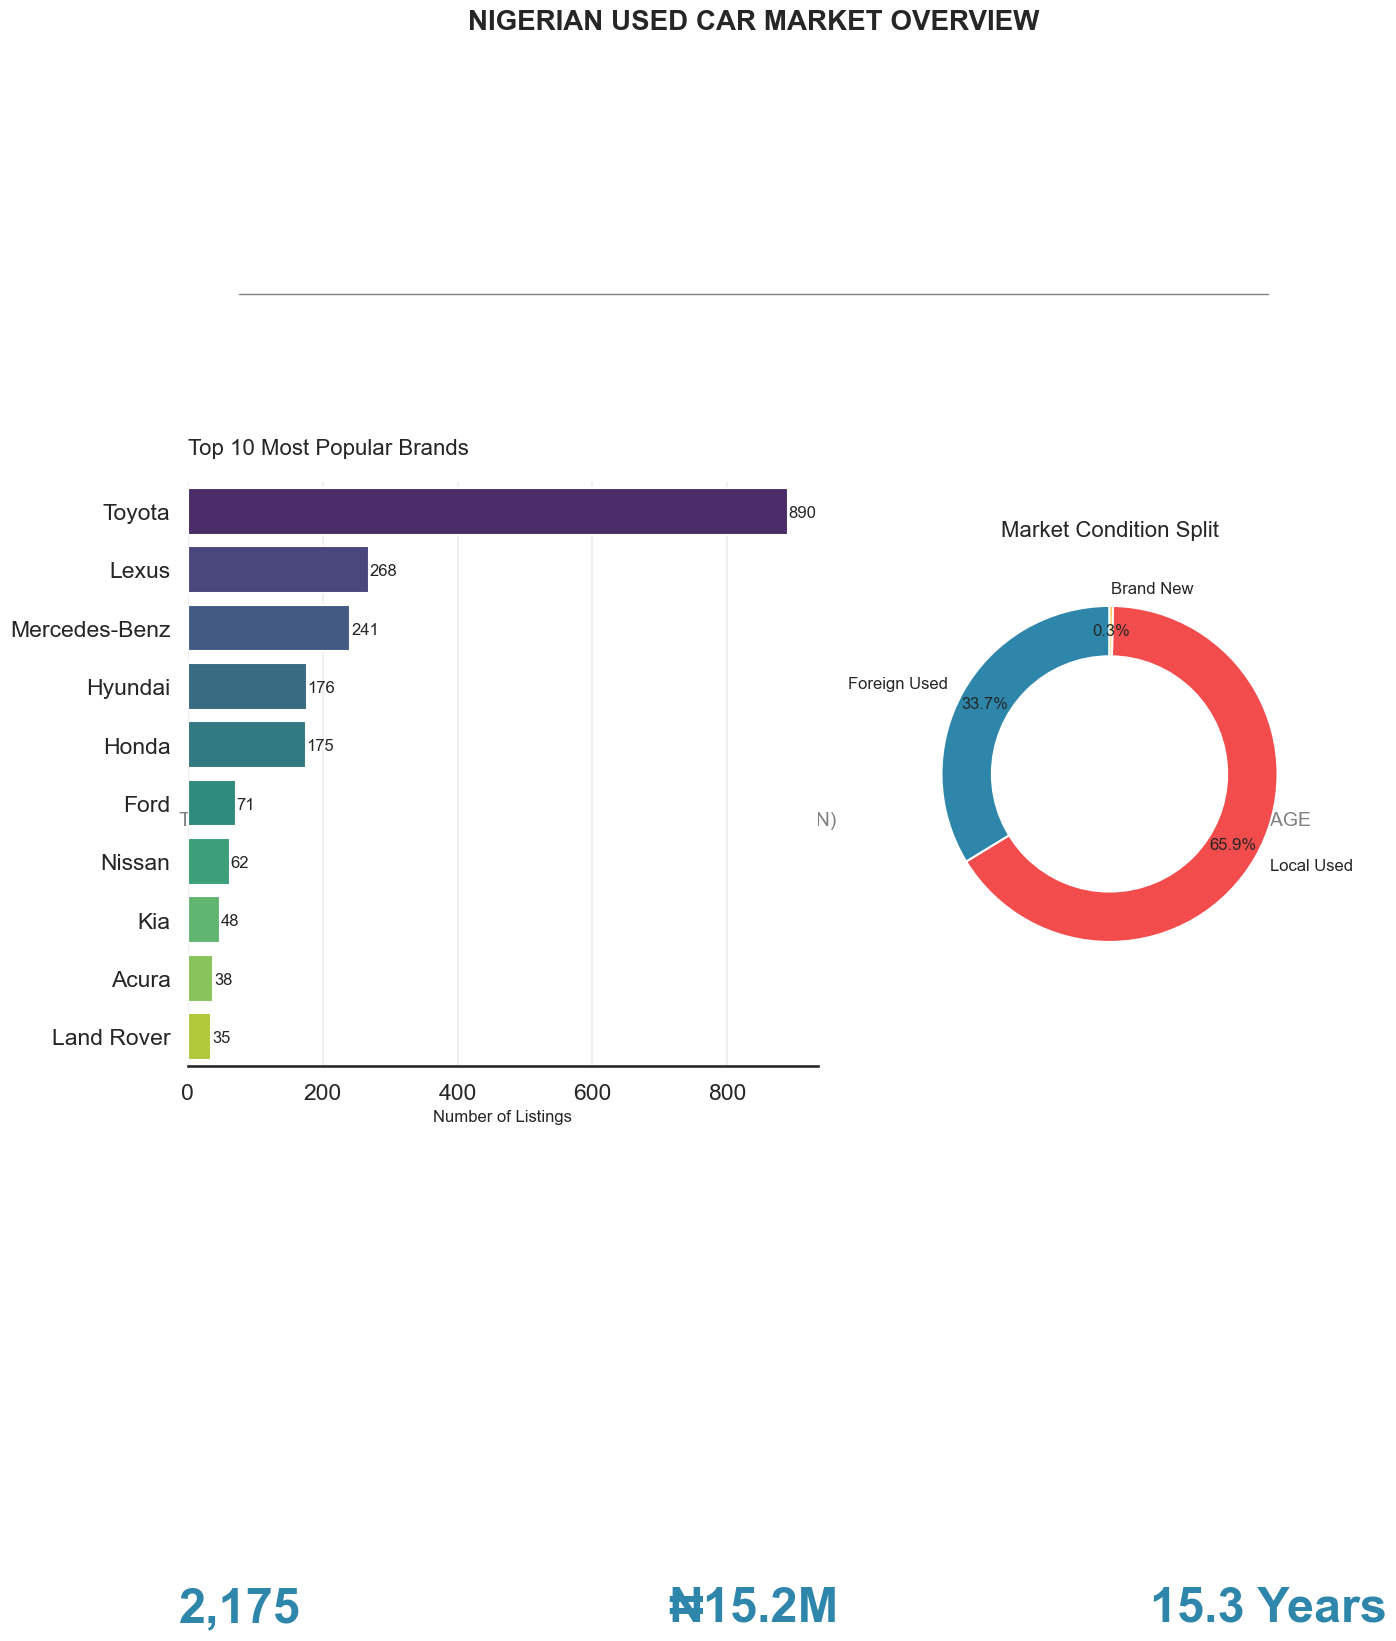

In [ ]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

conn = psycopg2.connect(
    dbname='car_analysis',
    user='postgres',
    password='_',
    host='localhost',
    port=5432
)

query_summary = """
SELECT
    COUNT(*) as total_cars,
    COUNT(DISTINCT make) as total_brands,
    AVG(price) as avg_price,
    AVG(car_age) as avg_age,
    COUNT(CASE WHEN condition = 'Foreign Used' THEN 1 END) as foreign,
    COUNT(CASE WHEN condition = 'Local Used' THEN 1 END) as local,
    COUNT(CASE WHEN condition = 'Brand New' THEN 1 END) as new
FROM cars
"""
df_sum = pd.read_sql_query(query_summary, conn)

query_brands = """
SELECT make, COUNT(*) as count
FROM cars GROUP BY make ORDER BY count DESC LIMIT 10
"""
df_brands = pd.read_sql_query(query_brands, conn)
conn.close()

#VISUALIZATION SETTINGS
sns.set_theme(style="white", context="talk")
plt.rcParams['font.family'] = 'sans-serif'
text_color = '#333333'


fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, height_ratios=[1, 2.5], width_ratios=[1.5, 1])


ax_text = fig.add_subplot(gs[0, :])
ax_text.axis('off')

total_cars = df_sum['total_cars'][0]
avg_price = df_sum['avg_price'][0]
avg_age = df_sum['avg_age'][0]

ax_text.text(0.1, 0.6, "TOTAL CARS", fontsize=14, color='gray', ha='center')
ax_text.text(0.1, 0.3, f"{total_cars:,}", fontsize=35, fontweight='bold', color='#2E86AB', ha='center')

ax_text.text(0.5, 0.6, "AVG PRICE (NGN)", fontsize=14, color='gray', ha='center')
ax_text.text(0.5, 0.3, f"₦{avg_price/1000000:.1f}M", fontsize=35, fontweight='bold', color='#2E86AB', ha='center')

ax_text.text(0.9, 0.6, "AVG AGE", fontsize=14, color='gray', ha='center')
ax_text.text(0.9, 0.3, f"{avg_age:.1f} Years", fontsize=35, fontweight='bold', color='#2E86AB', ha='center')

ax_text.text(0.5, 0.9, "NIGERIAN USED CAR MARKET OVERVIEW", fontsize=20, fontweight='bold', ha='center')
ax_text.plot([0.1, 0.9], [0.8, 0.8], color='gray', linewidth=1) # Underline

ax_bar = fig.add_subplot(gs[1, 0])

sns.barplot(x='count', y='make', data=df_brands, palette='viridis', ax=ax_bar, edgecolor=None)

ax_bar.set_title('Top 10 Most Popular Brands', fontsize=16, pad=20, loc='left')
ax_bar.set_xlabel('Number of Listings', fontsize=12)
ax_bar.set_ylabel('')
sns.despine(left=True, bottom=False)
ax_bar.grid(axis='x', alpha=0.3)

for i, v in enumerate(df_brands['count']):
    ax_bar.text(v + 1, i + 0.1, str(v), fontsize=12)

ax_pie = fig.add_subplot(gs[1, 1])

labels = ['Foreign Used', 'Local Used', 'Brand New']
sizes = [df_sum['foreign'][0], df_sum['local'][0], df_sum['new'][0]]
colors = ['#2E86AB', '#F24C4C', '#F7B32B'] # Blue, Red, Yellowish

wedges, texts, autotexts = ax_pie.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=90,
    colors=colors, pctdistance=0.85, textprops={'fontsize': 12}
)

centre_circle = plt.Circle((0,0),0.70,fc='white')
ax_pie.add_artist(centre_circle)

ax_pie.set_title('Market Condition Split', fontsize=16, pad=20)

plt.tight_layout()
plt.show()